In [2]:
import shelve
import os
import torch
import warnings
import random
from torch.utils.data import Dataset

In [3]:
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [90]:
class ModelData:
    def read_data(self, data_identifier: str, data_type: str):
        file_path = self.check_identifier(data_identifier)
        
        f = shelve.open(file_path[:-3], 'r')
        if data_type == 'train':
            data = f['train_dict']
        elif data_type == 'test':
            data = f['train_dict']
        else:
            raise Exception("invalid data type requested")
        f.close()
        return data
    
    def check_identifier(self, data_identifier: str):
        file_path = data_identifier
        if 'Data' not in data_identifier:
            file_path = os.path.join(os.getcwd(), 'Data', 'Data-'+data_identifier+'.db')
        
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"{file_path} not found")
        else:
            return file_path
        
        
    def labels_to_index_dict(self, data: dict):
        return {label : indx for indx, label in enumerate(data.keys())}
    
    def index_to_labels_dict(self, labels_to_index_dict: dict):
        return {indx : label for label, indx in labels_to_index_dict.items()}
    
    def get_nclasses(self, data: dict):
        return len(data.keys())
    
    def get_sample_sizes(self, data: dict, index_to_label_dict: dict):
        sample_sizes = []
        for indx in range(len(data)):
            label = index_to_label_dict.get(indx, None)
            sample_sizes.append(data[label].shape[1])
        return sample_sizes

    def get_max_batch_size(self, sample_sizes: list):
        return min(sample_sizes)*len(sample_sizes)
    
    def get_max_data_dim(self, data: dict):
        data_dims = [values.shape[0] for values in data.values()]
        return max(data_dims)

In [91]:
class TrainData(ModelData, Dataset):
    def __init__(self, data_identifier: str):
        self.data = self.read_data(data_identifier, 'train')
        self.nclasses = self.get_nclasses(self.data)
        self.labels_to_index = self.labels_to_index_dict(self.data)
        self.index_to_labels = self.index_to_labels_dict(self.labels_to_index)
        self.sample_sizes = self.get_sample_sizes(self.data, self.index_to_labels)
        self.max_batch_size = self.get_max_batch_size(self.sample_sizes)
        

    def __len__(self):
        total_samples = 0
        for value in self.data.values():
            total_samples += value.shape[1]
        return total_samples
    
    def __getitem__(self, index):
        if isinstance(index, tuple) and len(index) == 2:
            k = self.index_to_labels.get(index[0], None)
            return torch.unsqueeze(torch.from_numpy(self.data[k][:, index[1]]), 0)
        else:
            raise IndexError(f"{index} not supported")
        
    def get_data_dim(self):
        return self.get_max_data_dim(self.data)

In [92]:
class TestData(ModelData, Dataset):
    def __init__(self, data_identifier: str):
        self.data = self.read_data(data_identifier, 'test')
        self.labels_to_index = self.labels_to_index_dict(self.data)
        self.nclasses = self.get_nclasses(self.data)
        self.index_to_labels = self.index_to_labels_dict(self.labels_to_index)
        self.sample_sizes = self.get_sample_sizes(self.data, self.index_to_labels)

    def __len__(self):
        total_samples = 0
        for value in self.data.values():
            total_samples += value.shape[1]
        return total_samples
    
    def __getitem__(self, index):
        if isinstance(index, tuple) and len(index) == 2:
            k = self.index_to_labels.get(index[0], None)
            return torch.unsqueeze(torch.from_numpy(self.data[k][:, index[1]]), 0)
        else:
            raise IndexError(f"{index} not supported")
        
    def get_data_dim(self):
        return self.get_max_data_dim(self.data)
        

In [93]:
class TrainLoader:
    def __init__(self, data_source, batch_size: int = 0, n_iter: int = 1, shuffle: bool = False):
        self.data_source = data_source
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.returned_index = 0
        self.adjusted_batch_size = self.adjust_batch_size(batch_size)
        self.nsamples = self.get_nsamples()
        self.class_indices_r = self.get_randomized_class_indices()
        self.sample_indices_r = self.get_randomized_sample_indices()
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.n_iter > 0 and self.returned_index < self.adjusted_batch_size:
            c_indx, s_indx = divmod(self.returned_index, self.nsamples)
            self.returned_index += 1
            self.update_batch()
            if self.shuffle:
                indx = self.class_indices_r[c_indx], random.randrange(self.data_source.sample_sizes[c_indx])
                return self.data_source[indx]
            else:
                indx = self.class_indices_r[c_indx], (self.sample_indices_r[c_indx] + s_indx)
                return self.data_source[indx]
        else:
            raise StopIteration

    def update_batch(self):
        if self.returned_index == self.adjusted_batch_size:
            self.n_iter -= 1
            random.shuffle(self.class_indices_r)
            self.sample_indices_r = self.get_randomized_sample_indices()
            self.returned_index = 0
        
    def adjust_batch_size(self, batch_size: int):
        adjusted_batch_size = min(max(batch_size//self.data_source.nclasses, 1) * self.data_source.nclasses, self.data_source.max_batch_size)
        if adjusted_batch_size != batch_size:
            warnings.warn(f"batch size adjusted to {adjusted_batch_size}")
        return adjusted_batch_size

    def get_nsamples(self):
        return (self.adjusted_batch_size//self.data_source.nclasses)
    
    def get_randomized_class_indices(self):
        class_indices_r = [*range(self.data_source.nclasses)]
        random.shuffle(class_indices_r)
        return class_indices_r
    
    def get_randomized_sample_indices(self):
        sample_indices_r = []
        for indx in self.class_indices_r:
            random_start_limit = self.data_source.sample_sizes[indx] - self.nsamples
            sample_indices_r.append(random.randint(0, random_start_limit))
        return sample_indices_r
    
    def get_batch_size(self):
        return self.adjusted_batch_size

In [94]:
class TestLoader:
    def __init__(self, data_source):
        self.data_source = data_source
        self.returned_class_indx = 0
        self.returned_sample_indx = 0

    def __iter__(self):
        return self
    
    def __next__(self):
        if self.returned_class_indx < self.data_source.nclasses and self.returned_sample_indx < self.data_source.sample_sizes[self.returned_class_indx]:
            indx = self.returned_class_indx, self.returned_sample_indx
            self.returned_sample_indx += 1
            self.update_class()
            return self.data_source[indx]
        else:
            raise StopIteration
    
    def update_class(self):
        if self.returned_sample_indx == self.data_source.sample_sizes[self.returned_class_indx]:
            self.returned_class_indx += 1
            self.returned_sample_indx = 0

    def get_index_to_class_dict(self):
        return self.data_source.index_to_labels
    
    def get_class_to_index_dict(self):
        return self.data_source.labels_to_index

In [10]:
train_inputs = TrainData('May04-2357')
train_loader = TrainLoader(train_inputs, batch_size=128, n_iter=2)
test_inputs = TestData('May04-2357')
test_loader = TestLoader(test_inputs)

In [3]:
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)
logging.debug('This message should appear on the console')
logging.info('So should this')
logging.warning('And this, too')

DEBUG:This message should appear on the console
INFO:So should this


In [7]:
#import torch
from torch.nn.functional import normalize
from torch.linalg import multi_dot

def get_init_batch(train_inputs, n_batches: int=1):
    data_dim = train_inputs.get_data_dim()
    batch_size = int(0.25*len(train_inputs))
    train_loader = TrainLoader(train_inputs, batch_size=batch_size, n_iter=n_batches)
    adjusted_batch_size = train_loader.get_batch_size()
    init_tensor = torch.empty((n_batches, adjusted_batch_size, data_dim))
    for i, input in enumerate(train_loader):
        batch_number, sample_number = divmod(i, adjusted_batch_size)
        init_tensor[batch_number, sample_number, :] = torch.flatten(input, start_dim=0)
    return init_tensor

def get_effective_dim(S: torch.Tensor):
    assert S.dim() == 1, "singular values must be in 1D vector"
    S_n = S**2/torch.sum(S**2)
    n_comp = 0
    for i in range(len(S_n)):
        if torch.sum(S_n[:i]) > 0.95:
            n_comp = i+1
            break
    return n_comp

def randomizer_matrix(m: int, n: int):
    assert m >= n, f"m={m} should be greater than or equal to n={n}"
    _, _, V = torch.pca_lowrank(torch.rand(n, n), q=n)
    if m > n:
        random_matrix = normalize(torch.randn(m-n, n), p=2, dim=1)
        Vc = torch.mm(random_matrix, V)
        return torch.vstack((V, Vc))
    else:
        return V

def input_svd_matrices(init_batch: torch.Tensor):
    _, S, V = torch.pca_lowrank(init_batch)
    effective_dim = get_effective_dim(S)
    return V[:, :effective_dim], S[:effective_dim], effective_dim

def initialize_network_connections(layer_dims: list, data_identifier: str):
    train_inputs = TrainData(data_identifier)
    init_batch = get_init_batch(train_inputs)
    left_matrix, sigma, n = input_svd_matrices(init_batch)
    sigma_r = sigma**(-1/len(layer_dims))
    
    for dim in layer_dims:
        right_matrix = randomizer_matrix(layer_dims[dim], n)
        w = multi_dot([left_matrix, torch.diag(sigma_r), right_matrix.T])
        w_n = normalize(w, p=2.0, dim=1)
        left_matrix = right_matrix
    return None


In [163]:
from torch import nn

class Hash(nn.Module):
    def __init__(self, input_size: int, hash_length: int):
        super().__init__()
        self.fc = nn.Linear(input_size, hash_length, bias=False)
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor):
        assert x.dim() == 3
        out = self.fc(x)
        out = self.activation(out)
        return self.hash_function(torch.sign(out))
    
    def hash_function(self, out: torch.Tensor):
        out_f = torch.flatten(out, end_dim=1)
        hash_values = torch.empty((out_f.shape[0], 1))
        for indx, row in enumerate(out_f):
            hash_values[indx, 0] = sum(v*2**i for i, v in enumerate(reversed(row)))
        return hash_values.reshape(*out.shape[:-1], 1)


class MultiHash(nn.Module):
    def __init__(self, input_size: int, n_heads: int):
        super().__init__()
        self.n_heads = n_heads
        self.input_size = input_size
        self.hash_length = 2*input_size #find optimal number of partitions
    
    def forward(self, x: torch.Tensor):
        hash_tensor = torch.empty((*x.shape[:-1], self.n_heads))
        for head in range(self.n_heads):
            hash_layer = Hash(self.input_size, self.hash_length)
            hash_tensor[:, :, head] = torch.flatten(hash_layer(x), start_dim=1)
        return hash_tensor

# implement to get input indices or make sure that at max bach size inputs are generated orederly

In [277]:
import torch
from torch import nn
from torch.linalg import matrix_rank, multi_dot
from torch.nn.functional import normalize

class Thresholding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input: torch.Tensor, threshold: float=0.0):
        return input*(input > threshold)

class Feedforward(nn.Module):
    def __init__(self, weights: torch.Tensor):
        super().__init__()
        assert weights.dim() == 2, "connectivity matrix must be 2D"
        self.weights = normalize(weights, p=2, dim=0)
        self.expansion = weights.shape[0] < weights.shape[1]

    def forward(self, input: torch.Tensor):
        return torch.mm(input, self.weights)
    
    def update(self, weights: torch.Tensor, unit_norm: bool=True):
        self.weights =  normalize(weights, p=2, dim=0) if unit_norm else weights
    


class Recurrent(nn.Module):
    def __init__(self, weights: torch.Tensor, expansion: bool=False):
        super().__init__()
        assert weights.dim() == 2 and weights.shape[0] == weights.shape[1], "recurrent connections must be all to all and 2D"
        self.weights = weights
        self.expansion = expansion

    def forward(self, input: torch.Tensor):
        approx_recurrence = self.approximate_recurrence(input)
        return torch.mm(input, approx_recurrence)
    
    def update(self, weights: torch.Tensor):
        self.weights =  weights
    
    def approximate_recurrence(self, input: torch.Tensor):
        # check shape constrains and initialize selection variables
        m = input.shape[1]
        selection_diag = torch.zeros(m)
        selection_indx = torch.flatten(torch.argsort(input, descending=True), start_dim=0)
        
        # if dimension expansion perform a binary search
        if self.expansion:
            left, right = 0, m
            while left < right:
                mid = int(0.5*(left+right))
                selection_diag[selection_indx[:mid+1]] = 1
                sys_mat = self.system_matrix(selection_diag)
                if matrix_rank(sys_mat) < m:
                    right = mid
                else:
                    left = mid+1
                selection_diag[torch.nonzero(selection_diag)] = 0
            selection_diag[selection_indx[:left]] = 1 
        # else select top m values
        else:
            selection_diag[selection_indx[:m]] = 1
        
        # return selection diagonal
        return torch.inverse(self.system_matrix(selection_diag))
    
    def system_matrix(self, selection_diag: torch.Tensor):
        return torch.eye(len(selection_diag)) + torch.mm(torch.diag(selection_diag), self.weights) - torch.diag(selection_diag)
    


class DiscriminationModule(nn.Module):
    def __init__(self, weights: torch.Tensor, lr: float=0.99, lr_decay: float = 0.8, beta: float = 0.99):
        super().__init__()
        self.feedforward = Feedforward(weights)
        self.recurrent = Recurrent(self.recurrent_weights(), expansion=self.feedforward.expansion)
        self.activation = Thresholding()
        self.lr = lr
        self.lr_decay = lr_decay
        self.beta = beta
        self.velocity_hebb = torch.zeros(weights.shape[0], weights.shape[1])
        self.velocity_anti_hebb = torch.zeros(weights.shape[1], weights.shape[1])
        self.dropout = torch.ones(1, weights.shape[1]).bool()
        self.counter = 1

    def forward(self, input: torch.Tensor):
        assert input.dim() == 2 and input.shape[0] == 1, "input must be a row vector"
        out_ = self.feedforward(input)
        out_ = self.recurrent(out_)
        out_f = self.activation(out_, threshold=2*torch.std(out_).item())
        self.update(input, out_f)
        return out_f

    def recurrent_weights(self): 
        return torch.mm(self.feedforward.weights.T, self.feedforward.weights)
    
    def update(self, input: torch.Tensor, out_f: torch.Tensor):
        #print(torch.sum(self.dropout).item(), torch.sum(out_f>0).item())
        out_filtered = self.dropout*out_f
        norm_out_filtered = torch.norm(out_filtered, p='fro').item()
        self.velocity_hebb = self.beta*self.velocity_hebb + (1-self.beta)*torch.mm(input.T, out_filtered)/norm_out_filtered
        self.velocity_anti_hebb = self.beta*self.velocity_anti_hebb + (1-self.beta)*torch.mm(out_filtered.T, out_filtered)/norm_out_filtered**2
        #self.dropout = out_f < 0.7*torch.norm(out_f, p='fro').item()
        self.dropout = out_f == 0

    def organize(self):
        correction_factor = 1/(1 - self.beta**self.counter)
        updated_weights = (1 - self.lr)*self.feedforward.weights + correction_factor*self.lr*(self.velocity_hebb - torch.mm(self.feedforward.weights, self.velocity_anti_hebb))
        self.feedforward.update(updated_weights)
        self.recurrent.update(self.recurrent_weights())
        self.counter += 1
        self.lr = self.lr_decay*self.lr

    def connections(self):
        return self.feedforward.weights



class ClassificationModule(nn.Module):
    def __init__(self, weights: torch.Tensor):
        super().__init__()
        self.feedforward = Feedforward(weights)
        self.recurrent = Feedforward(torch.eye(weights.shape[1]))
        self.potential = torch.zeros(weights.shape[1], weights.shape[1])
        self.activation = Thresholding()

    def forward(self, input: torch.Tensor):
        assert input.dim() == 2 and input.shape[0] == 1, "input must be a row vector"
        out_ = self.feedforward(input)
        #out_ = self.activation(out_, threshold=2*torch.std(out_).item())
        out_ = self.recurrent(out_)
        out_f = self.activation(out_)
        self.update(out_f)
        return out_f
    
    def transform(self, out_f: torch.Tensor):
        out_f_transformed = -0.5*torch.ones(out_f.shape)
        out_f_transformed[out_f > 0] = 1.0
        return out_f_transformed
    
    def update(self, out_f: torch.Tensor):
        out_f_transformed = self.transform(out_f)
        update_matrix = torch.floor(torch.mm(out_f_transformed.T, out_f_transformed))
        self.potential += update_matrix
    
    def organize(self):
        print(torch.sum(self.recurrent.weights), end=" ")
        recurrent_weights = (self.potential > 0).float()
        self.recurrent.update(recurrent_weights, unit_norm=False)
        print(torch.sum(self.recurrent.weights))
        self.potential[:,:] = 0.0

    def connections(self):
        return self.recurrent.weights
    
    

In [5]:
import numpy as np
from matplotlib import pyplot as plt

init_proj = np.load('init_proj.npy')
proj = np.load('proj.npy')
test_set = np.load('test_set.npy')
print(init_proj.shape, " ", proj.shape)

(784, 1000)   (784, 1000)


In [244]:
n = 150
m = 500

inps = torch.tensor(test_set).float()
U, s, V = torch.pca_lowrank(inps.T, q=500, center=True)
#n_comp = get_effective_dim(s)
S_n = s**2/torch.sum(s**2)


s_inv = torch.diag(S_n[:n]**(-1))
randomizer = randomizer_matrix(m, n)
init_connections = multi_dot((V[:,:n], s_inv, randomizer.T))
init_connections_n = normalize(init_connections, p=2, dim=0)


In [293]:
connection_matrix = torch.randn(784, 500)
connection_matrix = connection_matrix.to(torch.float64).float()/784

module_d = DiscriminationModule(connection_matrix, beta=0.98, lr=0.2)
module_c = ClassificationModule(torch.eye(500))
for i, sample in enumerate(test_set.T): 
    #print(i, end=" ") 
    x = torch.unsqueeze(torch.tensor(sample).float(), 0)
    y_ = module_d(x)
    y = module_c(y_)

    module_d.organize() if i > 0 and not i%50 else None 
    module_c.organize() if i > 0 and not i%200 else None
    
    if i >= 2000:
        break
    

tensor(500.) tensor(225.)
tensor(225.) tensor(73.)
tensor(73.) tensor(60.)
tensor(60.) tensor(58.)
tensor(58.) tensor(58.)
tensor(58.) tensor(60.)
tensor(60.) tensor(59.)
tensor(59.) tensor(58.)
tensor(58.) tensor(58.)
tensor(58.) tensor(57.)


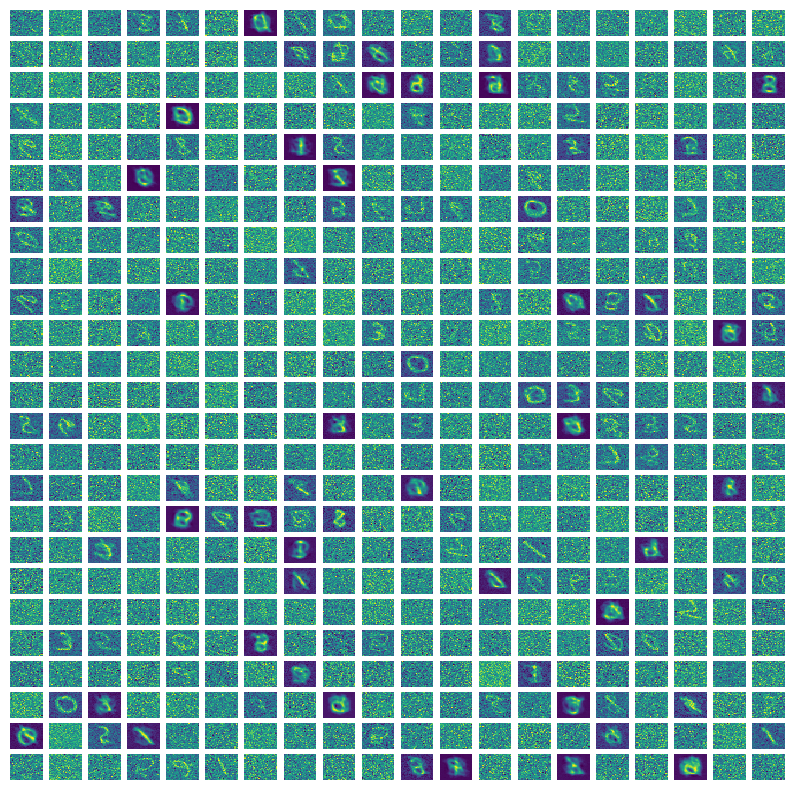

In [294]:

#connection_matrix = torch.randn(784, 1000)
wf = module_d.connections()
fig, ax = plt.subplots(25, 20, figsize=(10,10))
for n in range(500):
    i, j = divmod(n, 20)
    ax[i,j].pcolormesh(wf[:,n].reshape(28,28))
    ax[i,j].axis('off')


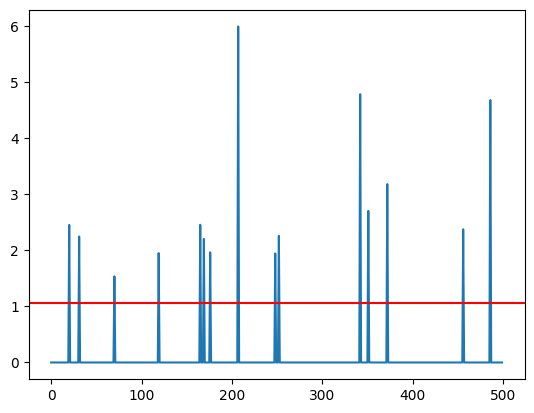

In [283]:
x = torch.unsqueeze(torch.tensor(test_set[:, 500].T).float(), 0)
y = module_d(x)
y_c = module_c(y)
plt.plot(y[0,:])
plt.axhline(2*torch.std(y).item(), color='red')

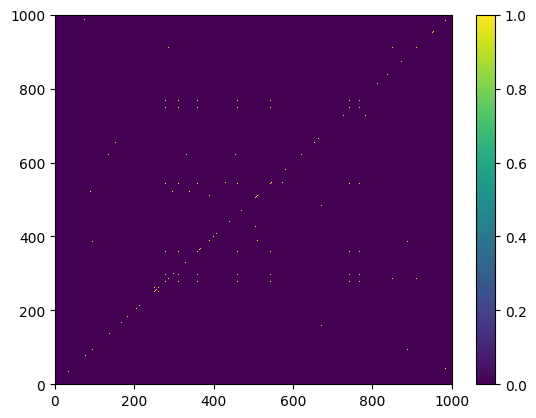

In [225]:
wc = module_c.connections()
plt.pcolormesh(wc)
plt.colorbar()

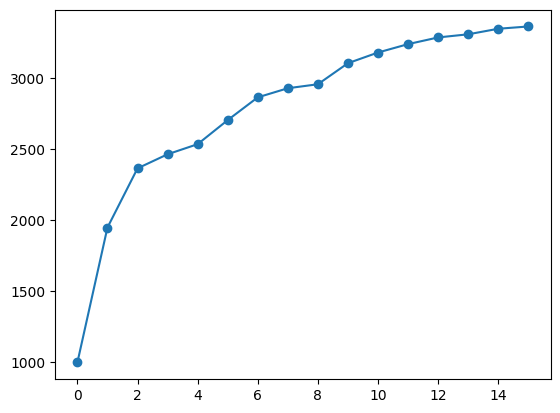

In [158]:
connections = [1000, 1948, 2364, 2463, 2534, 2703, 2863, 2927, 2955, 3103, 3178, 3237, 3284, 3306, 3345, 3361]
plt.plot(connections, 'o-')

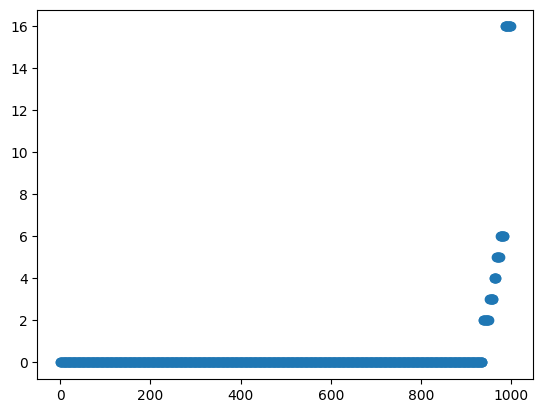

In [222]:
A = wc - torch.diag(torch.diag(wc))
D = torch.diag(torch.sum(A, dim=1))
L = D-A
vals, vecs = torch.linalg.eig(L)
vals_abs = torch.abs(vals)
vals_abs = vals_abs[torch.argsort(vals_abs)]
vecs = vecs[:, torch.argsort(vals_abs)]
plt.scatter(range(1000), vals_abs)
#plt.pcolormesh(torch.mm(A, torch.abs(vecs[:,:100])))
#plt.colorbar()

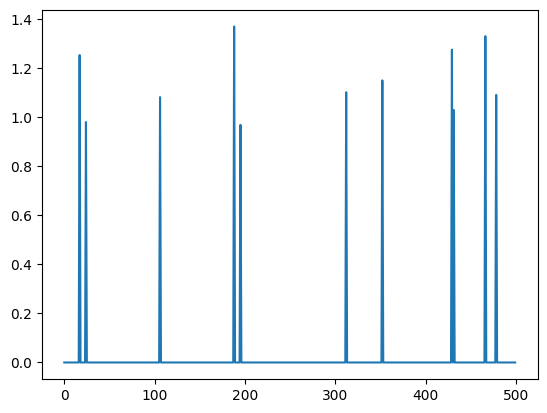

In [276]:
module_d = DiscriminationModule(torch.randn(784, 500), beta=0.98, lr=0.01)
x = torch.unsqueeze(torch.tensor(test_set[:, 1].T).float(), 0)
plt.plot(module_d(x)[0,:])